**Table of Contents**
<div id="toc"></div>

# 4 Amino Benzylamine acylation

This notebook is a supporting example for the presentation "[Accelerating High-Throughput Experimentation with Templated Statistical Analysis](https://aiche.confex.com/aiche/2018/meetingapp.cgi/Paper/530421)" Presented at the 2018 Annual AIChE meeting

*Jacob Albrecht*
*Bristol-Myers Squibb, 2018*


Factors Studied:
- AcOH (0, 2.5, 5M)
- TEA (0, 2.5, 5M)
- Ac2O (1, 1.25, 1.5M) 

Responses Measured:

- Product concentration
- Final pH
- Time to reach 1% starting material


## Background

This data is based off of the DynoChem reaction model for 4 Amino Benzylamine acylation, available here:

https://dcresources.scale-up.com/Default.aspx?id=2925

This is a reaction with two reactive groups with pH dependent selectivity. Acetic acid is formed as a byproduct of the reaction. For this example suppose the high pH product is desired and that either AcOH or TEA are added to control the pH of the reaction.  

<img src="exampleScheme.png" width="600px" height="auto">


The "experimental" data was generated for a fractional factorial design at four time points (0.5, 1,2, 4 hr) calculated from the  kinetic model.  For this example analysis, it is assumed that there is initially no knowledge of the underlying mechanisim and emprical models will be used to model the responses.

In [1]:
# Preliminaries:
options(warn=-1)  # turn off warnings
library(readxl)
library(rbokeh)
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tibble))
library(ggplot2)
library(reshape2)
library(AlgDesign)
library(repr)
suppressPackageStartupMessages(library(rstan))
suppressPackageStartupMessages(library(rstanarm))
suppressPackageStartupMessages(library(projpred))
library(corrplot)
suppressPackageStartupMessages(library(bayesplot))
options(jupyter.plot_mimetypes = 'image/png')  # avoid goofily-rendered plots
options(repr.plot.width=7, repr.plot.height=5)  # set ggplot size
ggplot2::theme_set(theme_bw())
options(mc.cores = parallel::detectCores()) # for multi thread stan
rstan_options(auto_write = TRUE)

## Load and Inspect data
Read the experimental data in and then show kinetic trends

In [2]:
# First, load the dataset:
sdt.file <- 'DoE_Example_Data.xlsx'
doe.sdt <- read_excel(sdt.file,sheet=1,skip=0) %>% data.frame() 


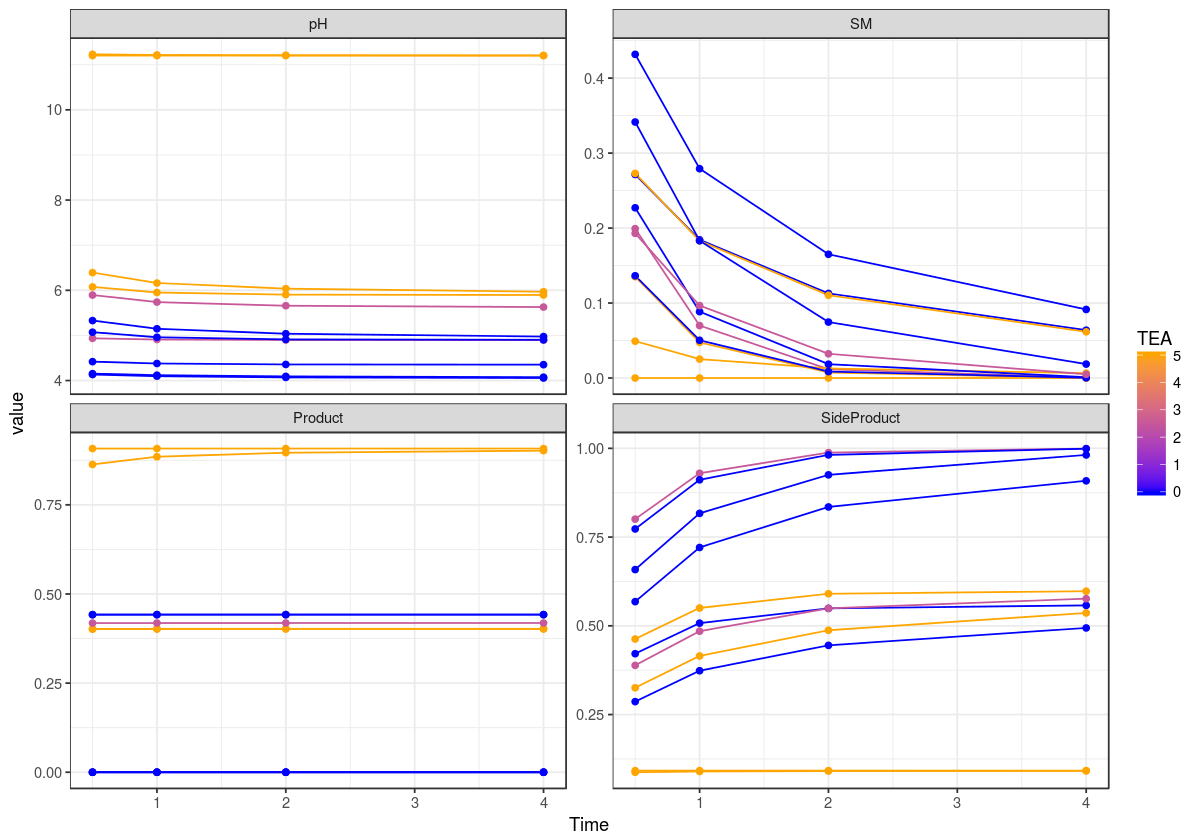

In [3]:
factors <- c('Ac2O','AcOH','TEA')
responses <- c('pH','SM','Product','SideProduct')
id <- c('Expt')
time <- c('Time')
doe.sdt[,factors]<-apply(doe.sdt[,factors],2,as.numeric)


melted <- melt(doe.sdt,measure.vars = responses)

options(repr.plot.width=10, repr.plot.height=7)  # set ggplot size
ggplot(melted,aes_string(x=time,y='value',group='Expt',color='TEA'))+geom_line()+geom_point()+
        facet_wrap(~variable,scale='free_y')+scale_color_gradient(low='blue',high='orange')


In [4]:
expdecay <-function (x,y,x.low=3,x.high=16){
    df <-data.frame(x=x,y=log(y))    
    mod <- lm(y~x,df[(df$x>=x.low)&(df$x<=x.high)&(is.finite(df$y)),])
    return(-mod$coefficients[2])
}

endpoint_interp <-function (time,ipc_value,obs,Expt,ipc_limit=1, print_plot=FALSE,doeID = NULL){    
    #print(unique(Expt))
    obs[is.na(obs)]<-0 # zero fill missing observations
    ipc_value[is.na(ipc_value)]<-0 # zero fill missing observations
    ipc_value[ipc_value==0] <- 1e-5 # add small non-zero number
    #print(list(time,ipc_value,obs))
     # limitations due to non-monotonic APs, forgive these hacks..
    ipc_dat <- data.frame(Expt,x=log10(ipc_value/ipc_limit),y=time) %>%
                            arrange(desc(x),y) %>% mutate(sign.x=sign(x),
                                                  lag.x = lag(sign.x,default=1),
                                                  lead.x =lead(sign.x,default=-1),
                                                  flip.x = lead.x!=lag.x)
    
    # select the two rows that bracket the IPC, or the two closest rows if limit is not reached
    #print( ipc_dat)
    if (sum(ipc_dat$flip.x)>=2){
        ipc_dat <- ipc_dat %>% filter(flip.x)
    }else{    
        ipc_dat <- ipc_dat[1:2,] 
    }
    #print(ipc_dat)
    time.complete <- signal::interp1(ipc_dat$x,ipc_dat$y,0,method='linear',extrap=T)
    #print(time.complete)
    stopifnot(is.finite(time.complete))
    extrapolated <- ifelse((time.complete>min(time)) & (time.complete < max(time)), FALSE,TRUE )
    
    obs_dat <- data.frame(Expt,timediff = time-time.complete,obs=obs,time=time) %>% 
                            arrange(timediff,obs) %>% mutate(sign.x=sign(timediff),
                                                         lag.x = lag(sign.x,default=sign.x[1]),
                                                         lead.x =lead(sign.x,default=sign.x[length(sign.x)]),
                                                         flip.x = lead.x!=lag.x) %>% distinct()
    fine.time <-  seq(min(obs_dat$time,na.rm=T),max(obs_dat$time,na.rm=T),by=1)
    even.len <- length(obs_dat$time)+length(obs_dat$time)%%2
    
    #print(data.frame(time,obs=obs))
    #print(obs_dat)
    Dobs <- signal::sgolayfilt(signal::interp1(obs_dat$time,obs_dat$obs,
                                              fine.time ,
                                               method='pchip'),
                               m=1,ts=median(diff(fine.time)),p=1)
    #print(list(fine.time=fine.time,Dobs=Dobs))
    
    #print(obs_dat)
    if (sum(obs_dat$flip.x,na.rm=TRUE)>=2){
        obs_dat <- obs_dat %>% filter(flip.x)
    }else{
        obs_dat <- obs_dat %>% top_n(-2,abs(timediff))
        
    }
    #print(obs_dat)
    obs.complete <- signal::interp1(obs_dat$timediff,obs_dat$obs,0,method='linear',extrap=T)
    #print(obs.complete)

    Dobs.complete <- signal::interp1(fine.time ,Dobs,time.complete,method='linear')
    
    if (print_plot){        
        p<-ggplot(rbind(melt(data.frame(time,obs,ipc_value),id.var='time'),
                        data.frame(time=fine.time ,variable='Dobs',value=Dobs)),
                  aes(x=time,y=value,color=variable))+geom_point()+geom_line()+
                geom_vline(aes(xintercept=time.complete))+
                geom_hline(aes(yintercept=obs.complete),color='red')+
                geom_hline(aes(yintercept=ipc_limit),color='#00BA38')+
                geom_hline(aes(yintercept=Dobs.complete),color='#619CFF')+
                scale_y_log10()+xlab('Time')
                #facet_wrap(~variable,scale='free_y',ncol=1)
        #print(ggplot_build(p)$data)
        print(p)
    }
    
    
    return(list(time.complete,obs.complete,Dobs.complete))
}

In [5]:
options(repr.plot.width=4, repr.plot.height=2.5)  # set ggplot size

In [6]:
doe.sdt.mutated <- doe.sdt %>% group_by(Expt) %>% 
                                    mutate(time.complete = endpoint_interp(Time,SM,SM,Expt,ipc_limit=0.01)[[1]],
                                          Product.complete= endpoint_interp(Time,SM,Product,Expt,ipc_limit=0.01)[[2]]) %>% data.frame()


In [7]:

# add new columns to responses
responses <- unique(c(responses,setdiff(names(doe.sdt.mutated),names(doe.sdt))))

# set endpoint
doe.sdt.endpts <- doe.sdt.mutated %>% filter(Time==4) %>% group_by(Expt) %>% data.frame()

Create a table for the min, max and median of the experimental factors and the measured and calculated responses:

In [8]:
# scale the responses for the model
doe.sdt.sc<-doe.sdt.endpts
doe.sdt.sc[,factors] <- scale(doe.sdt.endpts[,factors])

factors.responses <- c(factors,responses)

ranges <- sapply(doe.sdt.endpts[,factors.responses],
                 function(x){data.frame(min=min(x,na.rm=TRUE), median=median(x,na.rm=TRUE),
                                        max=max(x,na.rm=TRUE)
                                        )})
tranges = t(ranges)
tranges

,min,median,max
Ac2O,1,1.25,1.5
AcOH,0,2.5,5
TEA,0,2.5,5
pH,4.055932,4.975399,11.20646
SM,1e-20,0.004929198,0.09145335
Product,2.745919e-05,0.402271,0.9078902
SideProduct,0.09150739,0.5764841,0.9993939
time.complete,0.1802412,2.718748,4.819841
Product.complete,2.818898e-05,0.4022485,0.907858


In [9]:
# save data set for spotfire visualization
write.csv(doe.sdt.mutated[,c(id,time,factors,responses)],'Example.csv',row.names=FALSE)


In [10]:
# define some convenience functions to use for creating parity plots that can be inspected
bokeh_parity<- function(modl,unscaled.data,titl,col=NULL,filename='ParityPlot'){
    pred <- modl$fitted.values
    obs <- modl$residuals+modl$fitted.values
    data <- modl$model
    data$ID <- row.names(data)    
    tools <-  c("pan", "wheel_zoom", "box_zoom", "box_select", "resize", "reset","save","hover")
     p<-figure(tools=tools, width = 480, height = 320, xlab='Predicted', ylab='Observed', title=titl) %>%
          ly_points(pred,obs,legend=FALSE,color=as.factor(col),
                    hover=unscaled.data) %>%
          ly_abline(a=0,b=1, type = 2, legend = FALSE)%>% x_range(c(min(obs),max(obs)))  %>% set_theme(bk_ggplot_theme) 
    
    suppressMessages(rbokeh2html(p,paste0(filename,'.html')))
    
}
ggplot_parity<- function(modl,unscaled.data,titl,col=NULL,filename='ParityPlot'){
    pred <- modl$fitted.values
    obs <- modl$residuals+modl$fitted.values
    data <- modl$model
    
    #print(unscaled.data)
    #print(data)
    ID <- paste0("#",unscaled.data$Expt[as.numeric(row.names(data))])
    
    df <- data.frame(Predicted = pred, Observed = obs)
    p<-ggplot(df,aes(x=Predicted,y=Observed,label=ID))+geom_text(check_overlap=TRUE)+geom_abline(slope=1,intercept=0)
    ggsave(paste0(filename,'.png'),plot=p,width=4,height=3,units='in',dpi=300)
    IRdisplay::display_png(file=paste0(filename,'.png'),width=480,height=360)

}

plot_params<- function(modl,title='Parameter Estimates',filename='ParameterPlot',
                       width=4.8, height.per = 0.5){
    s <- summary(modl)
    deg.freedom <- s$df[2]  # get degrees of freedom
    crit.t <- qt(c(0.025,0.975),deg.freedom)   # calc critical t-values
    data.raw <- as.data.frame(s$coef[order(abs(s$coef[,3]),decreasing=T),]) # sort data, removing intercept
    
    data.raw <- data.raw[-which(row.names(data.raw)=='(Intercept)'),]
    
    #col <- data.frame(effects(modl)) # assign color to the effect magnitude
    terms <- gsub(':',' * ',as.character(row.names(data.raw)))
    
    if (length(data.raw)==0){
        return('No significant Parameters!')
    }
        
    data <- data.frame(term=terms,t.ratio=data.raw[,3],coefficient=data.raw[,1])
    #print(data)
    p<- ggplot(data,aes(x=reorder(terms, abs(t.ratio)),t.ratio,fill=coefficient))+geom_bar(stat='identity')+
    geom_hline(yintercept=crit.t[1],linetype = "longdash")+
    geom_hline(yintercept=crit.t[2],linetype = "longdash")+xlab('Model Term')+ylab('t Ratio')+
    scale_fill_gradient2(low = "blue", high = "orange",mid="violet")+
    coord_flip()+ggtitle(title)
    
    ggsave(paste0(title,'.png'),plot=p,width=width,
           height=(1.5+height.per*nrow(data)),units='in',dpi=300)
    IRdisplay::display_png(file=paste0(title,'.png'),width=100*width,
                           height=100*(1.5+height.per*nrow(data)))
}

effect_summary<-function(models,resp.ix,factors,responses,more.is.better=FALSE){
    modl<- models[[resp.ix]]
    coef.info<-summary(modl)$coefficients[-1,]    
    stopifnot(modl$df.residual>0)    
    text.indicator  <- function(x){
        s=ifelse(!xor((x['Estimate']>0) , more.is.better),'+','-')
        n= ifelse(x['Pr(>|t|)']<0.001,3,ifelse(x['Pr(>|t|)']<0.01,2,
                                               ifelse(x['Pr(>|t|)']<0.1,1,0)))        
        return(paste(rep(as.character(s),n),collapse=''))
    }
    
    if (!is.null(dim(coef.info))){
        scores<-data.frame(apply(coef.info,1,FUN=text.indicator))
    }else{
        # for single parameter models
        scores<-data.frame(text.indicator(coef.info))
        row.names(scores)<-row.names(summary(modl)$coefficients)[-1]
    }
    names(scores) <- responses[resp.ix]
    scores[,1]<-as.character(scores[,1])
    return(tibble::rownames_to_column(scores))
}


plot_data <- function(resp.ix,data,scaled.data,factors,responses,
                               numfactors_to_plot=5,show_trace=FALSE,upper_model='~.^2',alpha=0.34,
                               num_sig_factors = 4, mode = 'projpred',pct=0){    
    
    stopifnot(mode %in% c('projpred','stepwise'))
    
    if(mode == 'projpred'){
    df <- data.frame((cbind(scaled.data[,factors],resp=scaled.data[,responses[resp.ix]])))
    #print(df)
    p <- ncol(df)-1 # number of factors (subtract 1 column for the response)
    n <- nrow(df) # number obs
    p0 <- num_sig_factors # number of likely predictors guess
    tau0 <- p0/max((p-p0),1) * 1/sqrt(n)
    rhs_prior <- hs(global_scale=tau0)
    fitrhs <- stan_glm(as.formula(paste0('resp',upper_model)), data = df, prior=rhs_prior,
                       QR=TRUE, 
                       seed=8675309, refresh=0,verbose = FALSE,iter=5000)
    fitrhs_cvvs <- cv_varsel(fitrhs, method = 'forward', cv_method = 'LOO',
                             nloo = n, verbose = FALSE)
    if (show_trace){
        options(repr.plot.width=3, repr.plot.height=3)  # set ggplot size
        print(varsel_plot(fitrhs_cvvs, stats = c('rmse'), deltas=T))
    }
    # suggest size is pulling some wierd numbers.. maybe use varsel stats instead?
    #nv <- suggest_size(fitrhs_cvvs,alpha=alpha,pct=pct)
    varselstats <- varsel_stats(fitrhs_cvvs,stats = c('elpd', 'rmse','mlpd'),deltas=T)   
    nv <- min(varselstats[(varselstats$rmse-varselstats$rmse.se) < 0,'size'])
    #print(varselstats)
    numfactors_to_plot = nv  # overwrites number of factors to plot
    
    projrhs <- project(fitrhs_cvvs, nv = nv, ns = 4000)  # projrhs contains samples 
    if (show_trace){
        options(repr.plot.width=7, repr.plot.height=5)  # set ggplot size
        print(mcmc_areas(as.matrix(fitrhs)))  # plots all
    }
    # 
    #print(mcmc_areas(as.matrix(projrhs), pars = c(names(projrhs$varsel$vind[1:nv]))))
    #print(nv)
    selected.factors <- unlist(sapply(names(fitrhs_cvvs$varsel$vind[1:nv]),
                             function(x){ifelse(x %in% factors,x,factors[which.min(adist(factors,x))])}))
    
    selected.factors.expanded <- unique(c(names(selected.factors),
                                          unlist(strsplit(names(selected.factors),':'))))
    #print(names(selected.factors))
    #print(selected.factors.expanded)
    modl<- lm(as.formula(paste0("resp~",paste0(c("1",selected.factors.expanded),collapse='+'))), 
                            data=cbind(scaled.data[,factors],resp=scaled.data[,responses[resp.ix]]),
                           na.action=na.omit)
        
        } else if(mode=='stepwise'){
        
    modl<- MASS::stepAIC(lm(resp~.,                        
                    data=cbind(scaled.data[,factors],resp=scaled.data[,responses[resp.ix]]),
                   na.action=),
                 scope = list(lower= ~1, upper= as.formula(upper_model)),
                 direction='both',
                 trace=show_trace,
                k = log(nrow(scaled.data)))
    }
        
    ranked.factors <- rank(summary(modl)$coefficients[
        row.names(summary(modl)$coefficients) %in% factors,'Pr(>|t|)'],
                           ties.method='first')
    #print(ranked.factors)
    if (ranked.factors == 1){
        # hack to fix bad plots when only one factor is selected
        names(ranked.factors) = intersect(row.names(summary(modl)$coefficients),factors)
    }
    ranked.factors.all <-c(ranked.factors,setdiff(seq(factors),ranked.factors))
    names(ranked.factors.all) <-c(names(ranked.factors),setdiff(factors,names(ranked.factors)))
    

    x.ix <- which(names(ranked.factors.all)[ranked.factors.all==1] == factors)
    col.ix <-  which(names(ranked.factors.all)[ranked.factors.all==2] == factors)
    row.ix <-  which(names(ranked.factors.all)[ranked.factors.all==3] ==factors)
    column.ix <- which(names(ranked.factors.all)[ranked.factors.all==4] == factors)
    size.ix <-  which(names(ranked.factors.all)[ranked.factors.all==5] ==factors)

    p<- ggplot(data,aes_string(x=factors[x.ix],y=responses[resp.ix],color=factors[col.ix]))
    if(numfactors_to_plot<3){
      p <- p+ggtitle(paste0('Response ',responses[resp.ix]))
    }    
    if(numfactors_to_plot==3){
      p <- p+facet_wrap(as.formula(paste('~',factors[row.ix])))+
        ggtitle(paste0('Response ',responses[resp.ix],' faceted by ', factors[row.ix]))
    }                
    if(numfactors_to_plot>=4){
        p<- p+facet_grid(as.formula(paste(factors[row.ix],'~',factors[column.ix])))+
            ggtitle(paste0('Response ',responses[resp.ix],' faceted by ', factors[row.ix],' vs ',factors[column.ix]))    
    }                
    if (numfactors_to_plot<5){
        p <- p+ geom_point(alpha=0.5,size=10)
    }else{
        p<-p+geom_point(alpha=0.5,aes_string(size=(factors[size.ix])))
    }
    if(is.numeric(scaled.data[,factors[col.ix]])){
        p <- p+scale_colour_gradient(low = "blue", high = "orange")
    }
    print(p+theme(plot.title = element_text(size = 12)))
    return(modl)
}

In [11]:
mod<-list()
response.summary <-data.frame(rowname='')

In [12]:
options(repr.plot.width=7, repr.plot.height=5)  # set ggplot size
default.mode = 'projpred'  # should be "projpred" or "stepwise"

# Part 1: Endpoint Analysis

## Impact on Response: Product
Plot of Product concentration when the starting material has reached 1%.  This metric provides an indication of both selectivity as well as overall conversion.


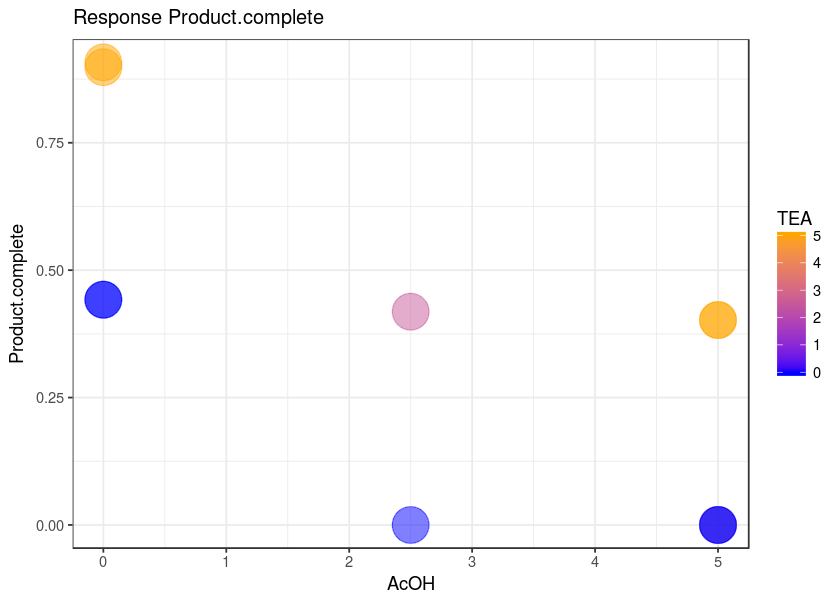

In [13]:
resp.ix <- which(responses=='Product.complete')
more.is.better=TRUE
mod[[resp.ix]]<-plot_data(resp.ix,doe.sdt.endpts,doe.sdt.sc,factors,responses,2,
                          upper_model = '~.^2',mode='projpred',show_trace=F)

<!DOCTYPE html>

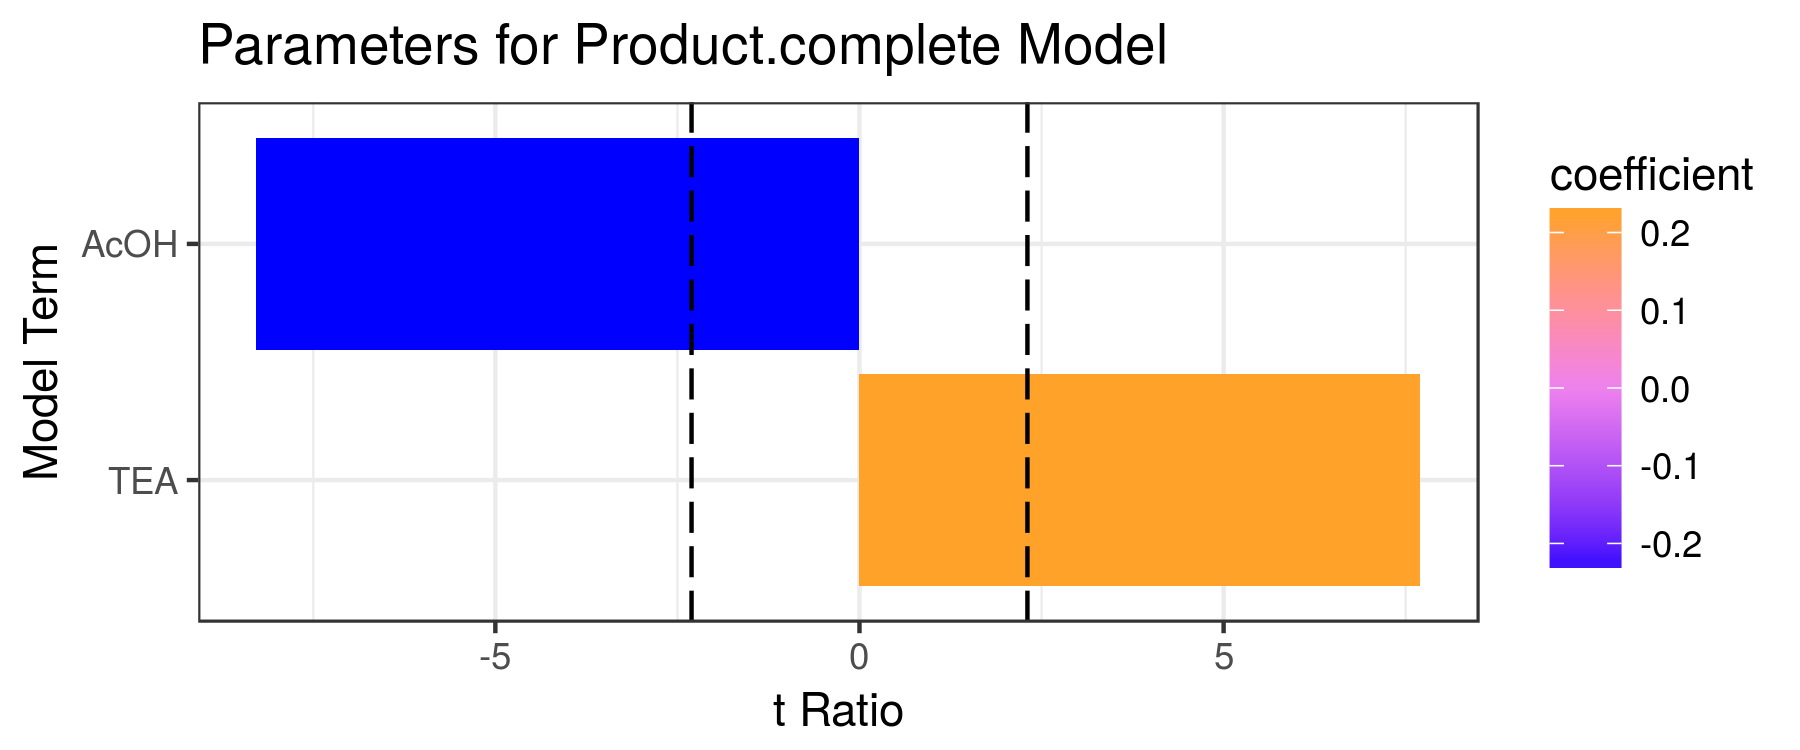

In [14]:
bokeh_parity(mod[[resp.ix]],doe.sdt.endpts[,c(id,factors)],
             responses[resp.ix],col=doe.sdt.sc[,id],filename=paste0('figure_',resp.ix))
IRdisplay::display_html(file=paste0('figure_',resp.ix,'.html'))

plot_params(mod[[resp.ix]],title=paste0('Parameters for ',responses[resp.ix],' Model'),width=6)
response.summary[responses[resp.ix]] <- NULL  # remove response column in case it already exists
response.summary <- full_join(response.summary,effect_summary(mod,resp.ix,factors,responses,more.is.better=more.is.better), by='rowname')

In [15]:
#summary(mod[[resp.ix]])

### Conclusion 
** Product concentration is favored with more TEA and less AcOH**

## Impact on Response: pH

Plot of endpoint pH

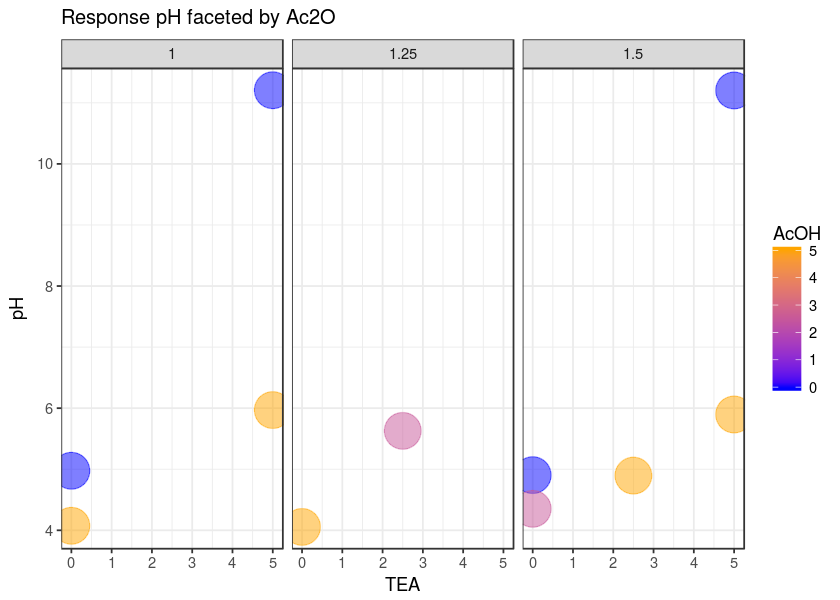

In [16]:
resp.ix <- which(responses=='pH')
more.is.better=TRUE
mod[[resp.ix]]<-plot_data(resp.ix,doe.sdt.endpts,doe.sdt.sc,factors,responses,3,
                          upper_model = '~.^2',mode='projpred',show_trace=F)

In [17]:
#summary(mod[[resp.ix]])

<!DOCTYPE html>

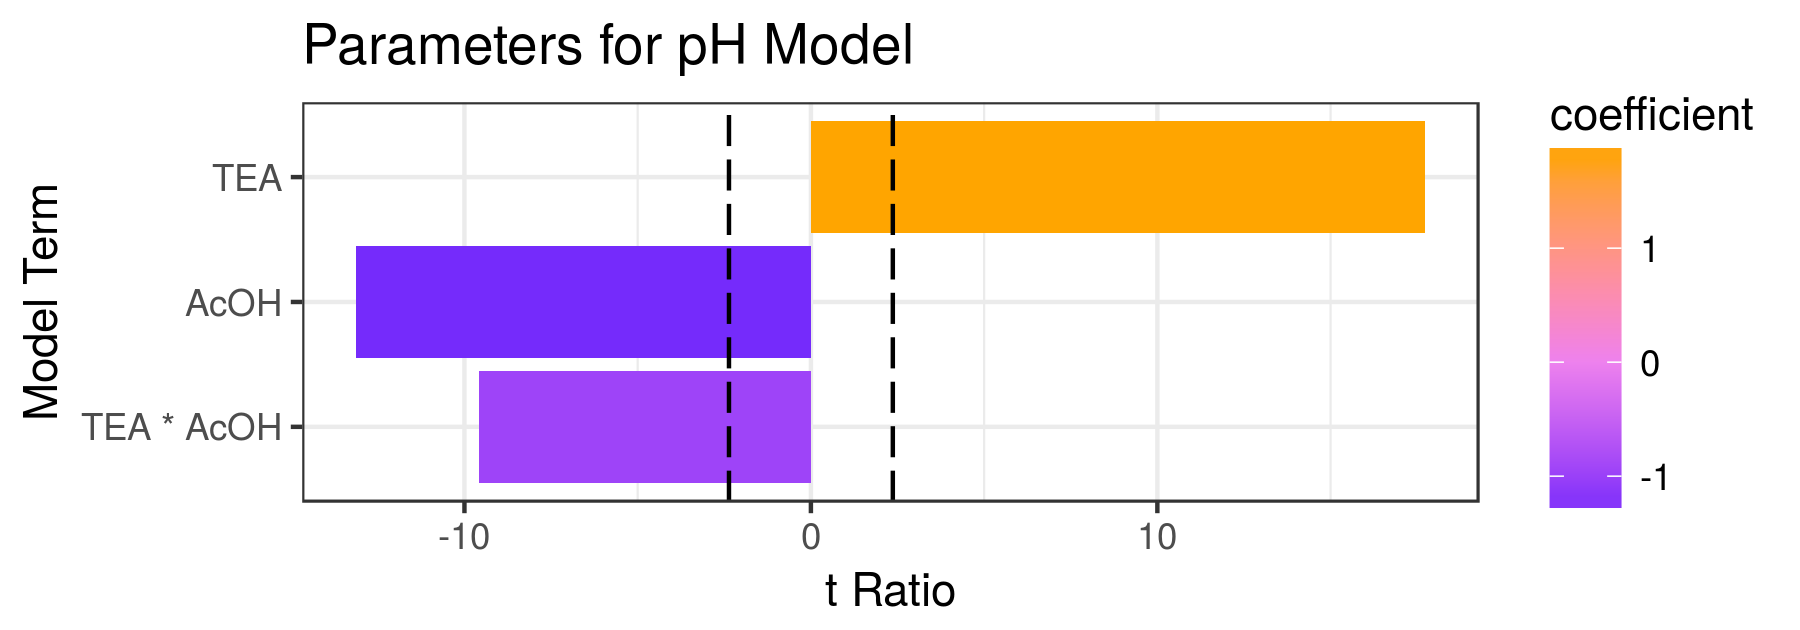

In [18]:
bokeh_parity(mod[[resp.ix]],doe.sdt.endpts[,c(id,factors)],
             responses[resp.ix],col=doe.sdt.sc[,id],filename=paste0('figure_',resp.ix))
IRdisplay::display_html(file=paste0('figure_',resp.ix,'.html'))

plot_params(mod[[resp.ix]],title=paste0('Parameters for ',responses[resp.ix],' Model'),width=6,height.per=0.2)
response.summary[responses[resp.ix]] <- NULL  # remove response column in case it already exists
response.summary <- full_join(response.summary,effect_summary(mod,resp.ix,factors,responses,more.is.better=more.is.better), by='rowname')

In [19]:
#summary(mod[[resp.ix]])

### Conclusion 
** Not surprisingly the pH increases with more base and decreases with more added acid. The significant TEA:AcOH interaction is important when the equivalents of added acid and base are equal**

## Impact on Response: Time to IPC
Plot of time that in process control (IPC) passes, i.e. time that starting material is less than 1%

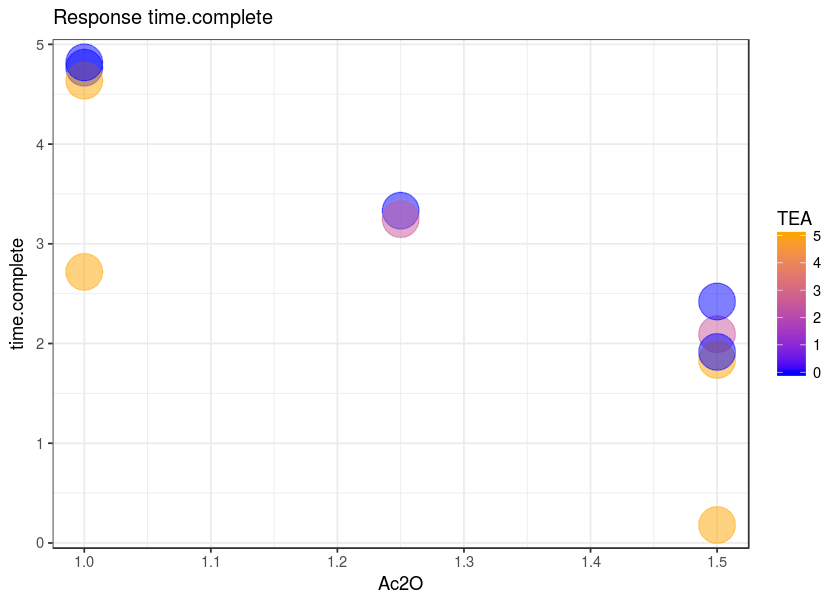

In [20]:
resp.ix <- which(responses=='time.complete')
more.is.better=FALSE
mod[[resp.ix]]<-plot_data(resp.ix,doe.sdt.endpts,doe.sdt.sc,factors,responses,2,
                          upper_model = '~.^2',mode='stepwise')

<!DOCTYPE html>

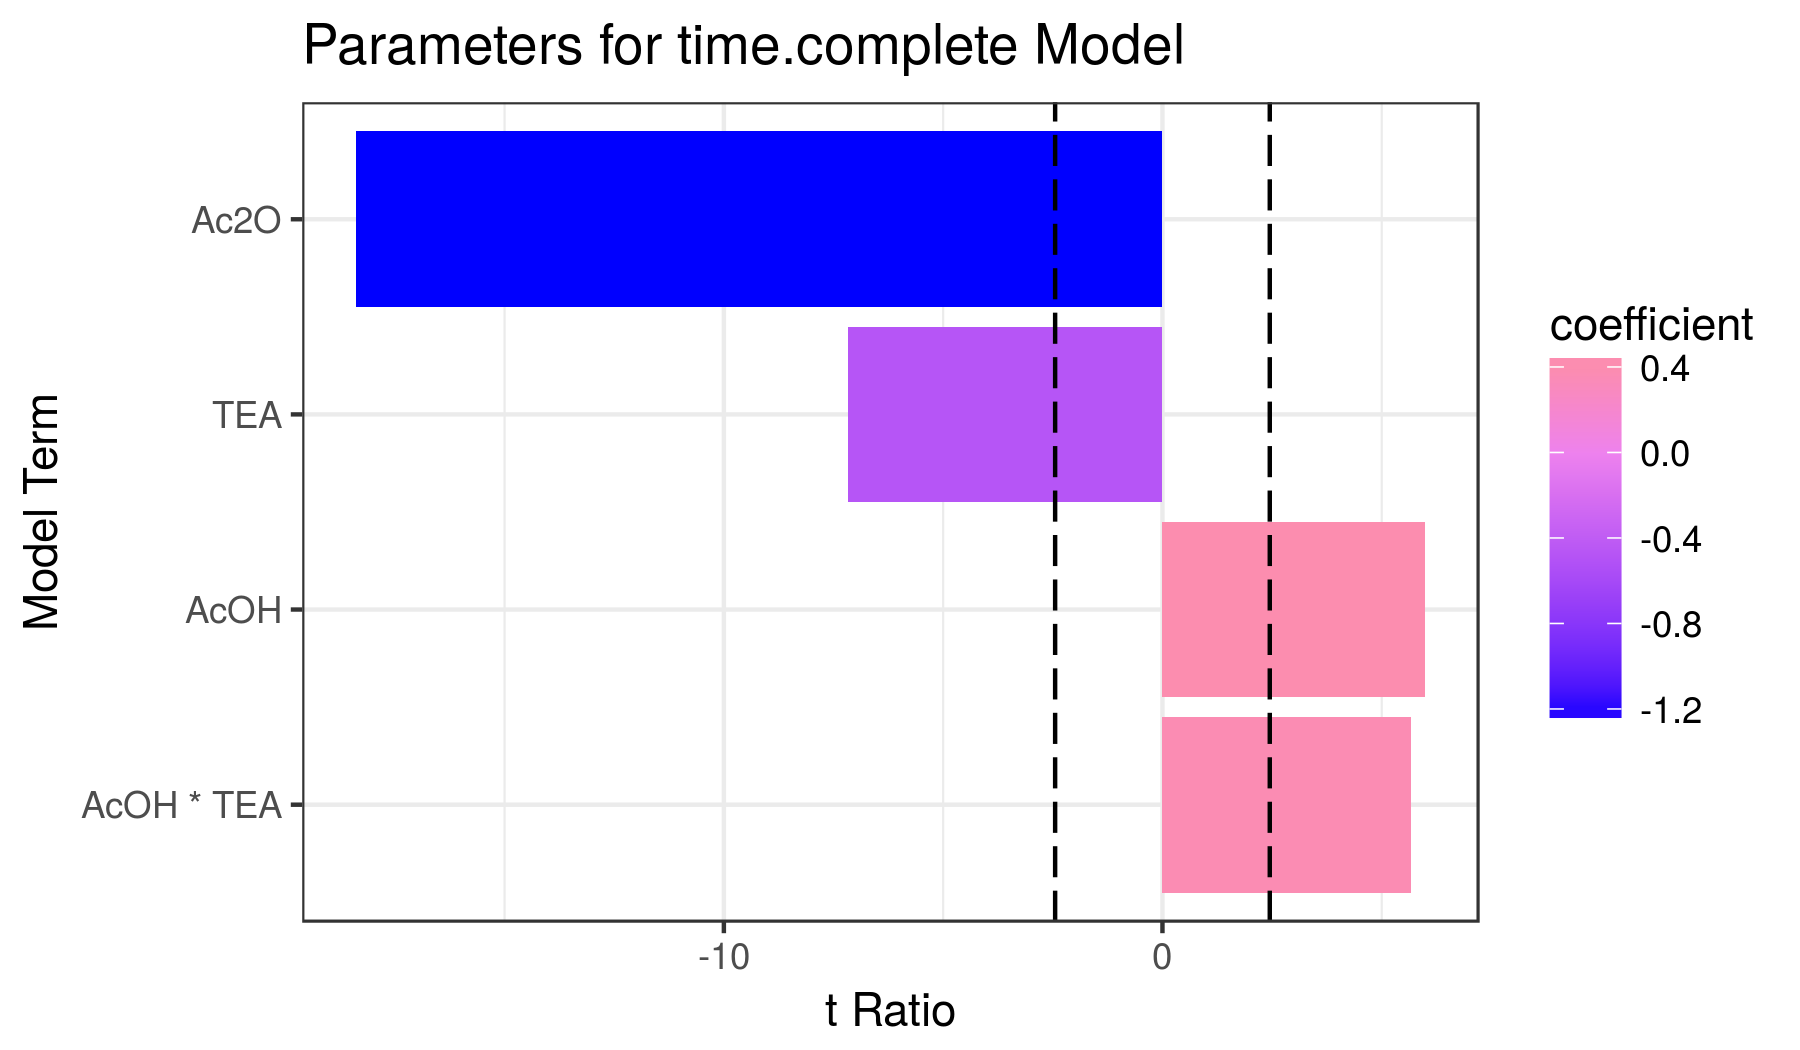

In [21]:
bokeh_parity(mod[[resp.ix]],doe.sdt.endpts[,c(id,factors)],
             responses[resp.ix],col=doe.sdt.sc[,id],filename=paste0('figure_',resp.ix))
IRdisplay::display_html(file=paste0('figure_',resp.ix,'.html'))

plot_params(mod[[resp.ix]],title=paste0('Parameters for ',responses[resp.ix],' Model'),width=6)
response.summary[responses[resp.ix]] <- NULL  # remove response column in case it already exists
response.summary <- full_join(response.summary,effect_summary(mod,resp.ix,factors,responses,more.is.better=more.is.better), by='rowname')

### Conclusion 
** The rate increases with more added acetic anhydride, and because the neutral starting material is consumed fastest, the high pH condition leads to lower reaction time. **

## Overall Summary

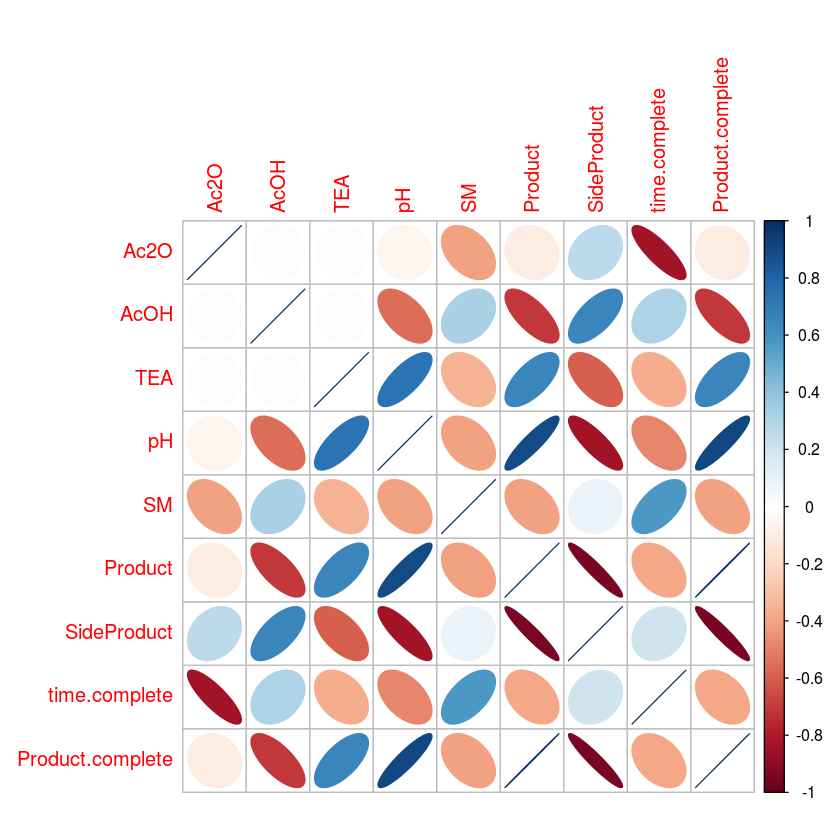

In [22]:
options(repr.plot.width=7, repr.plot.height=7)  # set ggplot size
corrdata <- doe.sdt.mutated[c(factors,responses)]
corrdata[is.na(corrdata)] <- 0

corrplot(cor(corrdata),method = "ellipse")

In [23]:
response.summary[is.na(response.summary)] <- ''
overall <- data.frame(t(response.summary[-1,]),stringsAsFactors=FALSE)
names(overall) <- overall[1,]
overall[-1,]

,AcOH,TEA,TEA:AcOH,Ac2O,AcOH:TEA
Product.complete,---,+++,,,
pH,---,+++,---,,
time.complete,---,+++,,+++,--


In [24]:
write.csv(overall[-1,],'OverallEffects_Example.csv')

# Contour Plots

In [25]:
conditions=data.frame(matrix(unlist(ranges[,factors]),ncol=length(factors)))
names(conditions) <- factors
row.names(conditions) <- c(-1,0,1)

new_design <- expand.grid(c(lapply(conditions,FUN=function(x){seq(-1,1,length.out=15)})))

resp.ix <- which(responses %in% c('pH','Product.complete','time.complete'))
for (i in resp.ix){
    predicted<- round(predict(mod[[i]],new_design,interval='prediction'),digits=2)
    new_design<- cbind(new_design,predicted)
    names(new_design)[(ncol(new_design)-2):ncol(new_design)] <- c(paste0('Predicted_',responses[i]),
                                             paste0('Predicted_lower_',responses[i]),
                                             paste0('Predicted_upper_',responses[i]))
}

# unscale factors
for (i in names(conditions)){
    f <- lm(y~x,data.frame(y=conditions[,i],x=as.numeric(row.names(conditions))))
    new_design[,i] <- round(predict(f,data.frame(x=new_design[,i])),digits=3)
}

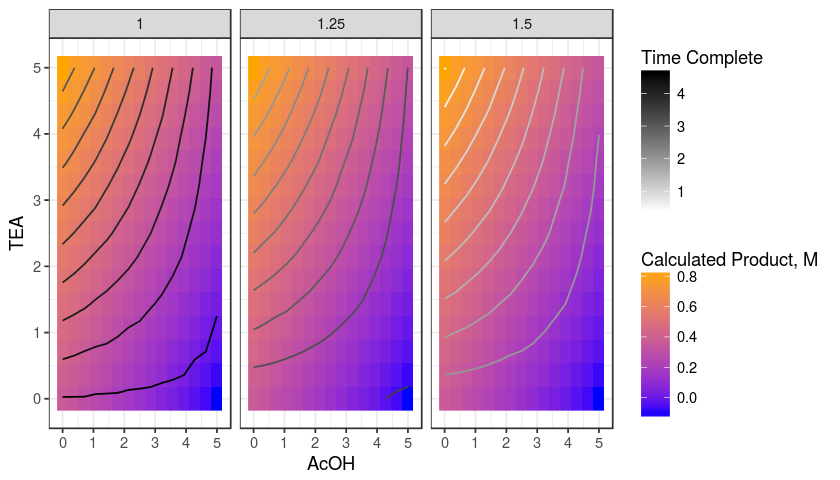

In [26]:
options(repr.plot.width=7, repr.plot.height=4)  # set ggplot size
contour.dat <- new_design %>% filter(Ac2O %in% c(1,1.25,1.5)) %>%
                group_by(AcOH,TEA,Ac2O)  %>%
                summarize(Product=min(Predicted_Product.complete,na.rm=T),
                          Time.Complete=min(Predicted_time.complete,na.rm=T),
                          Product.error = max(Predicted_upper_Product.complete-Predicted_lower_Product.complete,na.rm=T)/2,
                         ) %>%
                ungroup() %>% data.frame()

p <- ggplot(contour.dat,
        aes(x=AcOH,y=TEA,fill=Product))+geom_raster()+
    stat_contour(aes(z=Time.Complete,color=..level..))+facet_wrap(~Ac2O)+
    scale_fill_gradient(low='blue',high='orange')+
    scale_color_gradient(low='white',high='black')+labs(fill='Calculated Product, M',color='Time Complete')

print(p)

# Follow up runs

What would be the best conditions for follow up experimentation? Propose new conditions to augment the design:

In [27]:
number_new_runs <- 8
number_centers <- 3
resp.ix <- which(!unlist(lapply(mod,is.null)))

In [28]:

# hacky approach.. PRs welcome!
conditions=data.frame(matrix(unlist(ranges[,factors]),ncol=length(factors)))

names(conditions) <- factors
row.names(conditions) <- c(-1,0,1)


all.possible.scaled=gen.factorial(3,ncol(conditions),varNames=names(conditions))

# add customizations


filt = rep(TRUE,nrow(all.possible.scaled))
all.possible<-apply(all.possible.scaled[filt,],2,FUN=function(x){round(x,digits=2)})

centers <- data.frame(matrix(rep(0,length(factors)*number_centers),nrow=number_centers))
names(centers) <- factors

In [29]:
prev.runs <- doe.sdt.sc[,factors]
all.possible.aug<-rbind(prev.runs,all.possible)
row.names(all.possible.aug) <- NULL # reset row names

In [30]:
aug_design <- optFederov(~ .^2,
                       all.possible.aug,center=TRUE,nTrials=number_new_runs+nrow(prev.runs),
                       rows=seq(nrow(prev.runs)),maxIteration = 1e3,augment=TRUE)

print(aug_design$A)
new_design<-data.frame(aug_design$design[-seq(nrow(prev.runs)),])
new_design <- rbind(new_design,centers)

[1] 1.054405


In [31]:
row.names(new_design) <- NULL # remove row numbers


for (i in resp.ix){
    predicted<- round(predict(mod[[i]],new_design),digits=2)
    new_design<- cbind(new_design,predicted)
    names(new_design)[ncol(new_design)] <- paste0('Predicted_',responses[i])
}

for (i in names(conditions)){
    f <- lm(y~x,data.frame(y=conditions[,i],x=as.numeric(row.names(conditions))))
    new_design[,i] <- round(predict(f,data.frame(x=new_design[,i])),digits=3)
}


new_design$run.order <- sample(seq(number_new_runs+number_centers))

In [32]:
new_design

,Ac2O,AcOH,TEA,Predicted_pH,Predicted_time.complete,Predicted_Product.complete,run.order
1,1,0,0,4.66,4.61,0.37,9
2,1.5,0,0,4.66,2.12,0.37,3
3,1,5,0,3.91,4.65,-0.11,4
4,1.5,5,0,3.91,2.17,-0.11,11
5,1,0,5,10.28,2.88,0.82,7
6,1.5,0,5,10.28,0.39,0.82,10
7,1,5,5,5.61,4.45,0.34,6
8,1.5,5,5,5.61,1.96,0.34,5
9,1.25,2.5,2.5,6.11,2.9,0.36,1
10,1.25,2.5,2.5,6.11,2.9,0.36,8


In [33]:
write.csv(new_design,'AugmentedDesign.csv')

# Appendix: Write out session info to capture software versions 

In [34]:
sessionInfo()

R version 3.4.4 (2018-03-15)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 14.04.1 LTS

Matrix products: default
BLAS: /usr/lib/atlas-base/atlas/libblas.so.3.0
LAPACK: /usr/lib/atlas-base/atlas/liblapack.so.3.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] bindrcpp_0.2       bayesplot_1.5.0    corrplot_0.73      projpred_0.8.0    
 [5] rstanarm_2.17.4    Rcpp_0.12.14       rstan_2.17.3       StanHeaders_2.17.2
 [9] repr_0.4           AlgDesign_1.1-7.3  reshape2_1.4.3     ggplot2_2.2.1     
[13] tibble_1.4.1       dplyr_0.7.4        